# Advanced Machine Learning - programming assignment 2

**Please fill in:**
* Ernö Groeneweg (4279662)
* Otto Mättas (6324363)
* Vincent de Wit (6970877)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set.

In [1]:
import numpy as np
import itertools
import graphviz # conda install python-graphviz

The graphviz can draw graphs to different file formats, or show them directly in the notebook. We will use numpy arrays to represent graphs. The following function converts such an array to a graph in graphviz format. 

In [2]:
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

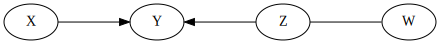

In [3]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a function that performs the PC algorithm. Add the missing code for phase 2, and implement phases 3 and 4.

In [4]:
def PC_algorithm(n, independence_tester):
    # PHASE I: Initialization
    # The matrix G represents a graph as follows:
    # - For all x, G[x,x] == False
    # - G[x,y] == False and G[y,x] == False: no edge between x and y
    # - G[x,y] == True  and G[y,x] == True:  undirected edge x --- y
    # - G[x,y] == True  and G[y,x] == False: directed edge x --> y
    G = np.logical_not(np.eye(n, dtype=bool))

    # PHASE II: Skeleton search
    # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
    sepset = dict()
    for k in range(n-1):
        for x in range(n):
            for y in range(n):
                if not G[x,y]:
                    continue
                # Try all subsets S of Adj(x) \ {y} with |S|=k,
                # until an independence is found.
                # Hint: use itertools.combinations
                
                # Your code here
                # G[x,y] is true here , this means that y is adjacent to x
                # for all S subset of adjacent nodes to x not including y, with size of S: |S|=k
                l = [i for i in range(n) if (i != y and i != x)] # range n excluding y and x since adj to x
                Set = itertools.combinations(l,k) # all combinations of length k
                
                for S in Set:
                    indep = independence_tester.test_independence(x, y, S)
                    if indep:
                        print("independence found: {0} and {1} given {2}".format(x,y,S))
                        G[x,y] = G[y,x] = False
                        S_mask = np.zeros(n, dtype=bool)
                        np.put(S_mask, S, True)
                        sepset[frozenset([x,y])] = S_mask
                        break
        # Do we need to continue with smaller k? ....
        max_S_size = np.sum(G, axis=0) - 1
        if np.all(max_S_size < k + 1):
            break

    # PHASE III: Orient v-structures
    # Something to watch out for:
    # If the data are not faithful to any graph, the algorithm may end up trying
    # to orient a single edge in two different ways. You can choose either
    # orientation if this happens.

    # Your code here
    # for two not adjacent nodes connected to a third node
    # check if this third node is in the sepset of the two
    # not connected nodes. When the third node is not in
    # the sepset, the two first nodes collide in the third.

    for x in range(n-1):
        for y in range(x,n):
            # if x and y not adjacent
            if G[x,y] == G[y,x] == False and x != y:
                for z in range(n):
                    
                    # when z is adjacent to x and to y
                    if G[x,z] == False and G[z,x] == False:
                        continue
                    if G[y,z] == False and G[z,y] == False:
                        continue
                        
                    # unordered when atleast one edge is undirected
                    if not (G[x,z]==G[z,x]==True or G[y,z]==G[z,y]==True):
                        continue
                        
                    # if z not in sepset({x,y}):
                    if not sepset[frozenset([x,y])][z]:
                        # orient edges
                        G[z,x] = G[z,y] = False
                        
        # Not implemented "Something to watch out for" I do not understand when this exactly would happen...

    # PHASE IV: Orientation rules

    # Your code here
    # no extra v-structures, no cycles
    
    # undirected edges
    for x in range(n):
        for y in range(n):
            # if x and y adjacent and undirected
            if not(G[x,y] == G[y,x] == True and x != y):
                continue
                
            # x and y adjacent and undirected
            for z in range(n):
                # remove cases where z is either x or y
                if z == x or z == y:
                    continue
                if G[x,z] == False and G[z,x] == True:
                    # Rule 1
                    if G[y,z] == False and G[z,y] == False:
                        G[y,x] = False
                        break
                    # Rule 2
                    if G[y,z] == True and G[z,y] == False:
                        G[x,y] = False
                        break
                # Rule 3    
                for q in range(n):
                    if q == z or q == x or q == y:
                        continue
                    if G[x,z] == G[z,x] == True and G[x,q] == G[q,x] == True:
                        if G[z,y] == True and G[y,z] == False:
                            if G[q,y] == True and G[y,q] == False:
                                G[y,x] = False

    '''
    rule 1: When a node has an incoming edge and an undirected edge
                    then the undirected edge becomes a directed outgoing edge.
    rule 2: When two nodes are connected by an undirected edge and 
                have a directed chain connecting them via a third node
                    then the undirected edge becomes a directed edge with the same direction as the chain.
    rule 3: When two nodes are connected by an undirected edge and
                one node has two incoming edges that 'relate' to the 'other' node
                    then the undirected edge becomes a directed edge directed at the node with incoming edges.
    '''
    

    return G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an /oracle/ instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, PC should be able to recover the Markov equivalence class of the true graph.

In [5]:
def is_d_connected_dfs(mB, pos, w, S, vis):
    # Made modifications to deal with CPDAGs as input
    #print("At ", pos)
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v])
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

class IndependenceOracle:
    def __init__(self, true_G):
        self.G = true_G
        self.n = true_G.shape[0]
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        #S_mask[S] = True
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph G1 we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

independence found: 0 and 2 given ()
independence found: 0 and 3 given ()
independence found: 1 and 3 given (2,)
CORRECT


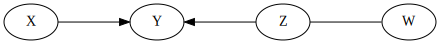

In [6]:
oracle = IndependenceOracle(G1)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G1) else "INCORRECT")
graph_to_graphviz(G, node_names)

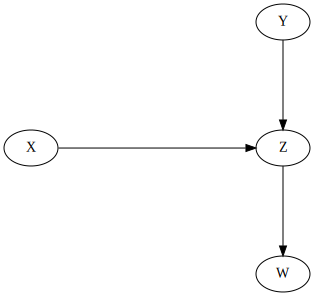

In [7]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (2,)
independence found: 1 and 3 given (2,)
CORRECT


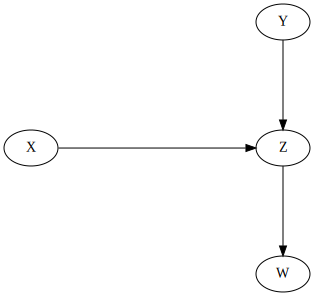

In [8]:
oracle = IndependenceOracle(G2)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G2) else "INCORRECT")
graph_to_graphviz(G, node_names)

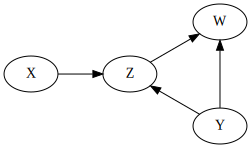

In [9]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (1, 2)
CORRECT


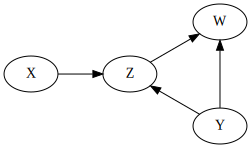

In [10]:
oracle = IndependenceOracle(G3)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G3) else "INCORRECT")
graph_to_graphviz(G, node_names)

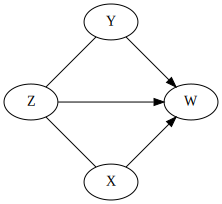

In [11]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: 0 and 1 given (2,)
CORRECT


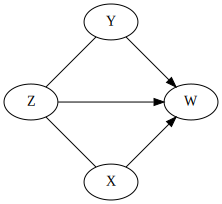

In [12]:
oracle = IndependenceOracle(G4)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G4) else "INCORRECT")
graph_to_graphviz(G, node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled 'experiment', indicates in which way that cell was prepared. We can think of experiment=1 as denoting the observational data, and other values of experiment (2 through 14) as various interventional datasets.

In [13]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking a logarithm
all_data.loc[:, all_data.columns != 'experiment'] = np.log(all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [14]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp1 = data_exp1.drop(columns='experiment')
data_exp1

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146
...,...,...,...,...,...,...,...,...,...,...,...
848,3.742420,3.317816,3.068053,4.218036,2.509599,2.113843,2.760010,6.331502,3.086487,3.391147,2.113843
849,4.128746,3.077312,2.257588,1.870263,3.535145,2.727853,3.139833,5.765191,2.476538,3.569533,3.929863
850,4.634729,3.471966,2.322388,2.580217,3.929863,1.663926,1.726332,5.476464,2.674149,3.131137,1.654411
851,4.352855,3.165475,3.210844,4.100989,3.795489,3.068053,3.218876,5.666427,3.471966,4.424847,3.299534


To run the PC algorithm on data, we need to perform (conditional) independence tests. The package [tigramite](https://github.com/jakobrunge/tigramite) implements several such tests. The simplest of these tests is ParCorr(). It assumes the data come from a linear model, which they actually don't. We will use it anyway, because the alternatives (such as CMIknn() (Runge, 2018)) are more effort to install and orders of magnitude slower.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a (much) larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [15]:
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        print("test: {0} and {1} given {2} -> pval={3}".format(x,y,S,pval))
        return pval > self.alpha

Could not import rpy package
Could not import r-package RCIT


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should have just one or two connected components.

test: 0 and 1 given () -> pval=2.763329247780076e-116
test: 0 and 2 given () -> pval=0.7345031780389384
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7147143030936396
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.4639779567396791
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.49429391475369566
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=0.24104570427628094
independence found: 0 and 6 given ()
test: 0 and 7 given () -> pval=0.8820017123329296
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=0.3264140832119329
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.11406363143778013
test: 0 and 10 given () -> pval=0.773348151789071
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.763329247780076e-116
test: 1 and 2 given () -> pval=0.9899798095695264
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.6357149945587127
indep

test: 8 and 10 given (7,) -> pval=2.751961739175646e-09
test: 8 and 10 given (9,) -> pval=8.310666644687424e-09
test: 9 and 8 given (0,) -> pval=3.9840486180425482e-78
test: 9 and 8 given (1,) -> pval=4.2638386924058854e-78
test: 9 and 8 given (2,) -> pval=2.5536743050191333e-78
test: 9 and 8 given (3,) -> pval=1.7201906588720365e-78
test: 9 and 8 given (4,) -> pval=2.477170564595105e-78
test: 9 and 8 given (5,) -> pval=1.455164310105671e-78
test: 9 and 8 given (6,) -> pval=2.363985891365964e-78
test: 9 and 8 given (7,) -> pval=4.4985527049632115e-78
test: 9 and 8 given (10,) -> pval=7.831749425050458e-78
test: 9 and 10 given (0,) -> pval=0.029877034992886017
test: 9 and 10 given (1,) -> pval=0.02483127781025555
test: 9 and 10 given (2,) -> pval=0.02967153693595061
test: 9 and 10 given (3,) -> pval=0.028586070334166516
test: 9 and 10 given (4,) -> pval=0.02864859473163029
test: 9 and 10 given (5,) -> pval=0.028574025085048506
test: 9 and 10 given (6,) -> pval=0.028954730690347645
test:

test: 3 and 4 given (5, 10) -> pval=4.618938780233255e-26
test: 3 and 4 given (6, 7) -> pval=6.25724687675847e-26
test: 3 and 4 given (6, 8) -> pval=4.7215661178934996e-26
test: 3 and 4 given (6, 9) -> pval=5.29144774598065e-26
test: 3 and 4 given (6, 10) -> pval=5.458081275341016e-26
test: 3 and 4 given (7, 8) -> pval=6.232892560233888e-26
test: 3 and 4 given (7, 9) -> pval=6.96689201652728e-26
test: 3 and 4 given (7, 10) -> pval=7.229440819591397e-26
test: 3 and 4 given (8, 9) -> pval=5.397635952637085e-26
test: 3 and 4 given (8, 10) -> pval=6.010702105973447e-26
test: 3 and 4 given (9, 10) -> pval=6.978268422523199e-26
test: 4 and 1 given (0, 2) -> pval=0.11399695640485098
test: 4 and 1 given (0, 3) -> pval=0.1988699027065482
test: 4 and 1 given (0, 5) -> pval=0.1135766987706972
test: 4 and 1 given (0, 6) -> pval=0.1180085885155085
test: 4 and 1 given (0, 7) -> pval=0.12147740636558009
test: 4 and 1 given (0, 8) -> pval=0.11940067114509807
test: 4 and 1 given (0, 9) -> pval=0.121541

test: 7 and 6 given (5, 9) -> pval=1.9771609162560015e-10
test: 7 and 6 given (5, 10) -> pval=1.5191350195409692e-10
test: 7 and 6 given (8, 9) -> pval=1.2489359371435342e-34
test: 7 and 6 given (8, 10) -> pval=1.3159399464955862e-34
test: 7 and 6 given (9, 10) -> pval=1.002777343791157e-34
test: 8 and 9 given (0, 1) -> pval=4.761870464931692e-78
test: 8 and 9 given (0, 2) -> pval=5.0464574687604125e-78
test: 8 and 9 given (0, 3) -> pval=3.4372827549176438e-78
test: 8 and 9 given (0, 4) -> pval=4.959202777032943e-78
test: 8 and 9 given (0, 5) -> pval=2.849841273124596e-78
test: 8 and 9 given (0, 6) -> pval=4.591473157935366e-78
test: 8 and 9 given (0, 7) -> pval=8.872890589603475e-78
test: 8 and 9 given (0, 10) -> pval=1.4992567389822578e-77
test: 8 and 9 given (1, 2) -> pval=5.426343724797999e-78
test: 8 and 9 given (1, 3) -> pval=3.658566424293394e-78
test: 8 and 9 given (1, 4) -> pval=5.335309104110153e-78
test: 8 and 9 given (1, 5) -> pval=3.104039607721982e-78
test: 8 and 9 given 

test: 10 and 9 given (1, 4) -> pval=0.024480683677975942
test: 10 and 9 given (1, 5) -> pval=0.02463187131141805
test: 10 and 9 given (1, 6) -> pval=0.02491882322569233
test: 10 and 9 given (1, 7) -> pval=0.02583505041383025
test: 10 and 9 given (1, 8) -> pval=0.12404703116702905
test: 10 and 9 given (2, 3) -> pval=0.02944027909681504
test: 10 and 9 given (2, 4) -> pval=0.029462842778090716
test: 10 and 9 given (2, 5) -> pval=0.029316486688695395
test: 10 and 9 given (2, 6) -> pval=0.029773438115388996
test: 10 and 9 given (2, 7) -> pval=0.03073380080563719
test: 10 and 9 given (2, 8) -> pval=0.11633651664867319
test: 10 and 9 given (3, 4) -> pval=0.02871850186337191
test: 10 and 9 given (3, 5) -> pval=0.028269812126955875
test: 10 and 9 given (3, 6) -> pval=0.028678544979692428
test: 10 and 9 given (3, 7) -> pval=0.029714263469001564
test: 10 and 9 given (3, 8) -> pval=0.11768682781883025
test: 10 and 9 given (4, 5) -> pval=0.02838480836261823
test: 10 and 9 given (4, 6) -> pval=0.028

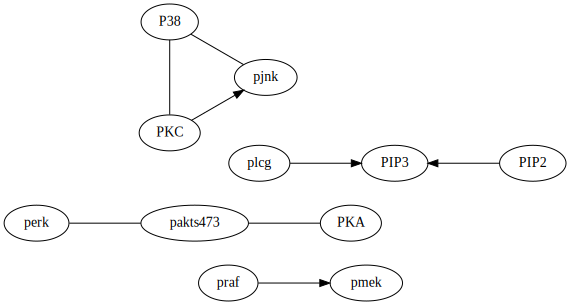

In [16]:
# Your code here
tester = IndependenceTester(data_exp1, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester)
graph_to_graphviz(G, list(data_exp1.columns))


Now let's look at what else is in the dataset: the interventional data corresponding to different experiments.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [17]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp5 = all_data[all_data.experiment==5]
data_exp6 = all_data[all_data.experiment==6]

data_exp1_5 = pd.concat([data_exp1, data_exp5], sort=False)
data_exp1_6 = pd.concat([data_exp1, data_exp6], sort=False)

In [18]:
data_exp1_5

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879,1
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037,1
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414,1
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833,1
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4194,4.110874,3.713572,1.376244,1.366092,2.985682,3.317816,3.795489,5.872118,3.363842,4.237001,3.552487,5
4195,4.254193,3.202746,0.000000,1.510722,3.758872,4.370713,5.043425,7.708411,1.376244,2.484907,3.508556,5
4196,4.136765,3.139833,1.205971,1.196948,2.660260,2.674149,3.317816,5.872118,2.879198,3.407842,1.223775,5
4197,4.727388,4.290459,0.000000,0.270027,2.442347,2.167910,3.437208,6.188264,3.688879,4.380776,3.777348,5


In [19]:
data_exp1_6

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879,1
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037,1
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414,1
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833,1
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,4.056989,4.515245,2.844909,2.753661,1.879465,1.591274,3.561046,4.804021,0.277632,3.005683,1.501853,6
4994,5.846439,6.386879,2.753661,2.493205,2.975530,0.000000,4.074142,5.062595,0.576613,3.471966,1.465568,6
4995,4.779123,5.056246,2.602690,4.795791,3.696351,0.989541,3.885679,5.147494,2.501436,3.374169,3.650658,6
4996,5.416100,5.872118,2.797281,2.995732,2.221375,3.020425,5.332719,8.014005,3.039749,4.434382,3.841601,6


**Question**: In the dataframe for experiments 1 and 5, look at PIP2 and the variables that were adjacent to it in the output of PC. Based on looking at some plots, does the data give evidence for or against the hypothesis that psitectorigenin modifies PIP2? And what does the data for the two experiments seem to say about the directions of the arrows between PIP2 and its neighbours?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Put your answer in markdown boxes, not as comments in your code!)

test: 0 and 1 given () -> pval=2.0376953059899394e-183
test: 0 and 2 given () -> pval=0.7288925242787185
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7124053354557727
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.791738305990526
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.10986481189123287
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=0.01472987772599981
independence found: 0 and 6 given ()
test: 0 and 7 given () -> pval=0.15894275506361807
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=0.5617195629350336
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.7455552457561689
independence found: 0 and 9 given ()
test: 0 and 10 given () -> pval=0.6894501241406117
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.0376953059899394e-183
test: 1 and 2 given () -> pval=0.2804036871272833
independence found: 1 and 2 given ()
test: 1 and 3 gi

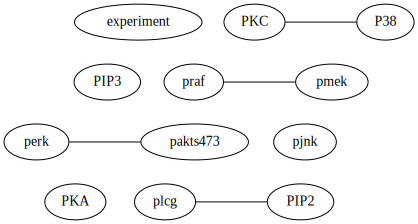

In [25]:
tester1_5 = IndependenceTester(data_exp1_5, ParCorr(), alpha=0.05e-100)

G = PC_algorithm(11, tester1_5)
graph_to_graphviz(G, list(data_exp1_5.columns))

**Answer**: 

**Question**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables you think might be relevant. Assume it is true that adding U0126 produces an intervention on the activity of pmek. What would you expect to see in the data if the graph found by PC was correct? What changes would you propose to that graph based on the data?

Again put your answer with accompanying plots in new boxes below here.

test: 0 and 1 given () -> pval=0.0
test: 0 and 2 given () -> pval=0.22579211347507994
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.03332165389820263
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.0018048301566494169
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=2.4846295816511114e-70
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=1.795947241414922e-29
independence found: 0 and 6 given ()
test: 0 and 7 given () -> pval=6.091908195017966e-12
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=4.579202937137639e-62
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.016423604063641198
independence found: 0 and 9 given ()
test: 0 and 10 given () -> pval=5.139426589447728e-26
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=0.0
test: 1 and 2 given () -> pval=0.10463195222143483
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.0

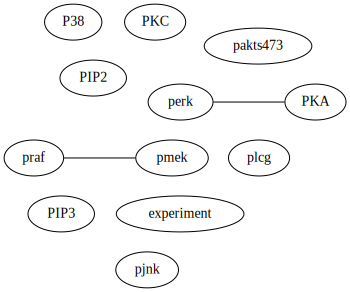

In [26]:
tester1_6 = IndependenceTester(data_exp1_6, ParCorr(), alpha=0.05e-100)

G = PC_algorithm(11, tester1_6)
graph_to_graphviz(G, list(data_exp1_6.columns))

**Answer**: 

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.